# Read DWD CDC Time Series, Merge with Station Description and Append 

The main idea behind this activity is to reformat and merge time series (here we use hourly precipitation) from the DWD Climate Data Center in such a way that it can be used with the **QGIS time manager extension**. 

This extension allows to filter an attribute table of a vector layer (e.g. points representing precipitation stations plus precipitation data) with a time stamp column. The extension limits the attribute table to the records matching the particular time stamp provided by the time manager extension (e.g. by the user moving the time slider). This selected subset of the attribute table is then used to change the sympology of the vector layer according to the variable of interest (e.g. precipitation rate).

The QGIS time manager extension approach is a bit brute force, because each individual measurement at a station at a given time is one feature (row in the table), i.e. a time series at station X with hourly resolution for a day (24 values) entails 24 different features with the same station id and the corresponding coordinates but different times. As of now this 1:n relationship can only be realized by importing a CSV file with the according structure. 

(At least I was not able to generate the required view on a 1:n relationship by merging a point vector layer with precipitation station locations and an imported CSV time series table.)

The final data format is a concatenation of time series together with geographic location in 2D (e.g. lat, lon). The required data format looks principly like this:


| station_id |        name        |   lat   |   lon  |        meas_time       | prec_rate |
|:----------:|:------------------:|:-------:|:------:|:----------------------:|:---------:|
|        ... | ...                |     ... |    ... |                    ... |       ... |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T08:00:00UTC |       1.5 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T09:00:00UTC |       1.7 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T10:00:00UTC |       0.1 |
|        ... | ...                |     ... |    ... |                    ... |       ... |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T08:00:00UTC |       0.8 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T09:00:00UTC |       0.4 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T10:00:00UTC |       0.0 |
|        ... | ...                |     ... |    ... |                    ... |       ... |


(Table generated with https://www.tablesgenerator.com/markdown_tables)

To achieve this the precipitation time series (station_id, meas_time, prec_rate) have to be merged with the station metadata (station_id, lat, lon) coming from the a CSV file generated in an earlier activity. We use Pandas to read, join and append the data to generate the final CSV file to be imported as a point layer to QGIS. 

This final data format is far from being optimal because of large size and highly redundant information. This is a challenge for QGIS which loses responsiveness with large data. To jsut show the principle it is advisable to limit to size of the problem. 

The following filters (selection criteria) are applied:

  * Precipitation stations in NRW only (approx. 127 stations) 
  * Hourly precipitation data
  * Time interval from 2018-12-01 to last date in precipitation data set 
  
Still: 40 days * 24 hrs / day * 127 stations = 121920 records leading to 121920 features in a point layer in QGIS. 

In fact, the resulting number of records is arround 91000. The reason might be that not all stations in the station list have time series. This has to be checked carefully.

## FTP Connection

### Connection Parameters

In [31]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""

### FTP Directory Definition and Station Description Filename Pattern

In [32]:
# The topic of interest.
topic_dir = "/daily/kl/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [33]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [34]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//daily/kl/historical/
data/original/DWD//daily/kl/historical/

data/generated/DWD/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/
data/generated/DWD//daily/kl/historical/


In [35]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [36]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [37]:
ret = ftp.cwd(".")

In [38]:
#ftp.quit()

### FTP Grab File Function

In [39]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")






### Generate Pandas Dataframe from FTP Directory Listing

In [40]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [41]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [42]:
df_ftpdir.head(10)

station_id                                               name   ext  \
0          -1  BESCHREIBUNG_obsgermany_climate_daily_kl_histo...  .pdf   
1          -1  DESCRIPTION_obsgermany_climate_daily_kl_histor...  .pdf   
2          -1           KL_Tageswerte_Beschreibung_Stationen.txt  .txt   
3           1     tageswerte_KL_00001_19370101_19860630_hist.zip  .zip   
4           3     tageswerte_KL_00003_18910101_20110331_hist.zip  .zip   
5          11     tageswerte_KL_00011_19800901_20181231_hist.zip  .zip   
6          44     tageswerte_KL_00044_19690101_20181231_hist.zip  .zip   
7          52     tageswerte_KL_00052_19690101_20011231_hist.zip  .zip   
8          61     tageswerte_KL_00061_19750701_19780831_hist.zip  .zip   
9          70     tageswerte_KL_00070_19730601_19860930_hist.zip  .zip   

     size type  
0   74902    -  
1   73419    -  
2  267457    -  
3  282024    -  
4  887544    -  
5   83682    -  
6  416393    -  
7  261747    -  
8   32904    -  
9  100354    -

### Dataframe with TS Zip Files

In [43]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

name   ext    size type
station_id                                                                   
1           tageswerte_KL_00001_19370101_19860630_hist.zip  .zip  282024    -
3           tageswerte_KL_00003_18910101_20110331_hist.zip  .zip  887544    -
11          tageswerte_KL_00011_19800901_20181231_hist.zip  .zip   83682    -
44          tageswerte_KL_00044_19690101_20181231_hist.zip  .zip  416393    -
52          tageswerte_KL_00052_19690101_20011231_hist.zip  .zip  261747    -
61          tageswerte_KL_00061_19750701_19780831_hist.zip  .zip   32904    -
70          tageswerte_KL_00070_19730601_19860930_hist.zip  .zip  100354    -
71          tageswerte_KL_00071_19861101_20181231_hist.zip  .zip  200328    -
72          tageswerte_KL_00072_19780901_19950531_hist.zip  .zip  155186    -
73          tageswerte_KL_00073_19590101_20181231_hist.zip  .zip  448711    -

### Download the Station Description File

In [44]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

KL_Tageswerte_Beschreibung_Stationen.txt


In [45]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//daily/kl/historical/KL_Tageswerte_Beschreibung_Stationen.txt


In [46]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [47]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
1          1937-01-01 1986-06-30       478   47.8413     8.8493   
3          1891-01-01 2011-03-31       202   50.7827     6.0941   
11         1980-09-01 2020-02-06       680   47.9737     8.5205   
44         1969-01-01 2020-02-06        44   52.9336     8.2370   
52         1969-01-01 2001-12-31        46   53.6623    10.1990   

                                   name                state  
station_id                                                    
1                                  Aach    Baden-Württemberg  
3                                Aachen  Nordrhein-Westfalen  
11          Donaueschingen (Landeplatz)    Baden-Württemberg  
44                         Großenkneten        Niedersachsen  
52                 Ahrensburg-Wulfsdorf   Schleswig-Holstein

### Select Stations Located in NRW from Station Description Dataframe

In [48]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    3,    98,   186,   326,   386,   390,   553,   554,   555,
              598,
            ...
            13696, 13700, 13713, 13901, 13952, 15000, 15120, 15190, 15200,
            15963],
           dtype='int64', name='station_id', length=112)

In [49]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Nordrhein-Westfalen"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() #original

print(df_stations.date_to.max())
#print(isoperational)

isBefore1950 = df_stations['date_from'] < '1950'

# select on both conditions
dfNRW = df_stations[isNRW & isOperational & isBefore1950]
#print("Number of stations in NRW: \n", dfNRW.count())
print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

2020-02-06 00:00:00
Number of stations in NRW: 
 date_from    9
date_to      9
altitude     9
latitude     9
longitude    9
name         9
state        9
dtype: int64


date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
1300       1938-01-01 2020-02-06       351   51.2540     8.1565   
1303       1935-01-01 2020-02-06       150   51.4041     6.9677   
1327       1937-01-01 2020-02-06       147   50.7119     6.7905   
2483       1926-11-01 2020-02-06       839   51.1803     8.4891   
2497       1947-01-01 2020-02-06       505   50.5014     6.5264   
2629       1947-11-11 2020-02-06        46   51.7612     6.0954   
2968       1945-01-01 2020-02-06        43   50.9894     6.9777   
4371       1935-01-01 2020-02-06       135   52.1042     8.7521   
5717       1937-01-01 2020-02-06       134   51.2256     7.1052   

                             name                state  
station_id                                              
1300                       Eslohe  Nordrhein-Westfalen  
1303               Essen-Bredeney  Nordrhein-Westfalen  
1327        Weilerswist-Lommersum  Nordrhein-Westfalen  
2483                 Kahler Asten  Nordrhein-Westfalen  
2497                  Kall-Sistig  Nordrhein-Westfalen  
2629                        Kleve  Nordrhein-Westfalen  
2968               Köln-Stammheim  Nordrhein-Westfalen  
4371               Salzuflen, Bad  Nordrhein-Westfalen  
5717        Wuppertal-Buchenhofen  Nordrhein-Westfalen

In [50]:
list_lon=[]
list_lat=[]
for index,row in dfNRW.iterrows():
    list_lon.append(row['longitude'])
    list_lat.append(row['latitude'])
print(list_lon)
print(list_lat)

[8.1565, 6.9677, 6.7905, 8.4891, 6.5264, 6.0954, 6.9777, 8.7521, 7.1052]
[51.254, 51.4041, 50.7119, 51.1803, 50.5014, 51.7612, 50.9894, 52.1042, 51.2256]


In [51]:
from geopy import distance
from geopy import Point

# mystation = point("6.94 51.5496")
# print (lon)

list_dist_station=[]

for f, b in zip(list_lon, list_lat):
    myP= str(f)+" "+str(b)
    mystation = Point(myP)
    xanten = Point("6.4349 51.6802")

    result = distance.distance(mystation,xanten).kilometers
    list_dist_station.append(result)
print(list_dist_station)
l1 = sorted(list_dist_station)[:3]
l1
res = [list_dist_station.index(i) for i in l1]
stations_dist_min_df=dfNRW.iloc[res]

[196.12555653669196, 66.3602277806431, 114.0710942209292, 233.7850928607713, 130.78246122742812, 38.599589113184805, 97.14282169850112, 260.5035720685089, 89.55763599673283]


In [52]:
stations_dist_min_df
# i got kleve for on the basis of minimum distance
# for measuring the temperature

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
2629       1947-11-11 2020-02-06        46   51.7612     6.0954   
1303       1935-01-01 2020-02-06       150   51.4041     6.9677   
5717       1937-01-01 2020-02-06       134   51.2256     7.1052   

                             name                state  
station_id                                              
2629                        Kleve  Nordrhein-Westfalen  
1303               Essen-Bredeney  Nordrhein-Westfalen  
5717        Wuppertal-Buchenhofen  Nordrhein-Westfalen

In [53]:
print(df_zips)

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_KL_00001_19370101_19860630_hist.zip  .zip  282024    -
3           tageswerte_KL_00003_18910101_20110331_hist.zip  .zip  887544    -
11          tageswerte_KL_00011_19800901_20181231_hist.zip  .zip   83682    -
44          tageswerte_KL_00044_19690101_20181231_hist.zip  .zip  416393    -
52          tageswerte_KL_00052_19690101_20011231_hist.zip  .zip  261747    -
...                                                    ...   ...     ...  ...
15963       tageswerte_KL_15963_19540101_20041130_hist.zip  .zip  337919    -
15965       tageswerte_KL_15965_19690501_19840831_hist.zip  .zip  101940    -
15979       tageswerte_KL_15979_19480101_19790331_hist.zip  .zip  221448    -
16085       tageswerte_KL_16085_19600701_19611231_hist.zip  .zip   16284    -
19087       tageswerte_KL_19087_19570501_19951130_hist.zip  .zip

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [54]:
list (stations_dist_min_df.index)

[2629, 1303, 5717]

In [55]:
# list(dfNRW.index)

In [56]:
# Add the names of the zip files only to a list. 
local_zip_list = []
# modification line 
station_ids_selected = list(stations_dist_min_df.index)
print(station_ids_selected)

# station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)
print(local_zip_list)

[2629, 1303, 5717]
tageswerte_KL_02629_19471111_20181231_hist.zip
tageswerte_KL_01303_19350101_20181231_hist.zip
tageswerte_KL_05717_19370101_20181231_hist.zip
['tageswerte_KL_02629_19471111_20181231_hist.zip', 'tageswerte_KL_01303_19350101_20181231_hist.zip', 'tageswerte_KL_05717_19370101_20181231_hist.zip']


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [57]:
def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [58]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]
#     modifiy code
    
#      df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])


    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [59]:
from zipfile import ZipFile

In [60]:
def ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [61]:
def temp_ts_merge(start,end):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                
                sensing_1=(dftmp.index >= start) & (dftmp.index <= end)
                df_sensing_1=dftmp.loc[sensing_1]
                print(df_sensing_1)
                
                s = df_sensing_1["tmk"].rename(df_sensing_1["stations_id"][0]).to_frame()
                
#                 station id column key zero index py data hy us ko user kr k 
#                 dftmp ky ja_tt column ko name krta hi 
                
                print(s)
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [62]:
df_merged_ts = temp_ts_merge('2015-05-01','2016-05-01')
df_merged_ts2 = temp_ts_merge('2016-05-26','2017-05-26')
df_merged_ts3 = temp_ts_merge('2017-06-30','2018-06-30')

x=df_merged_ts[2629].mean(axis=0)
y=df_merged_ts2[2629].mean(axis=0)
z=df_merged_ts3[2629].mean(axis=0)

list_TM_mean=[x,y,z]
print(list_TM_mean)


Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_02629_19471111_20181231_hist.zip
Extract product file: produkt_klima_tag_19471111_20181231_02629.txt

            stations_id  qn_3  fx  fm  qn_4   rsk  rskf  sdk  shk_tag  nm  \
mess_datum                                                                  
2015-05-01         2629   NaN NaN NaN   3.0   0.0   0.0  NaN      NaN NaN   
2015-05-02         2629   NaN NaN NaN   3.0   0.0   0.0  NaN      NaN NaN   
2015-05-03         2629   NaN NaN NaN   3.0   7.0   4.0  NaN      NaN NaN   
2015-05-04         2629   NaN NaN NaN   3.0  10.2   4.0  NaN      NaN NaN   
2015-05-05         2629   NaN NaN NaN   3.0   2.9   4.0  NaN      NaN NaN   
...                 ...   ...  ..  ..   ...   ...   ...  ...      ...  ..   
2016-04-27         2629   NaN NaN NaN   3.0   5.5   4.0  NaN      0.0 NaN   
2016-04-28         2629   NaN NaN NaN   3.0   0.5   4.0  NaN      0.0 NaN   
2016-04-29         2629   NaN NaN NaN   3.0   1.3   4.0  NaN  

            stations_id  qn_3    fx   fm  qn_4   rsk  rskf     sdk  shk_tag  \
mess_datum                                                                    
2016-05-26         1303  10.0   8.0  1.8     3   0.0   4.0   8.500      NaN   
2016-05-27         1303  10.0   7.1  2.7     3   0.0   0.0   5.367      NaN   
2016-05-28         1303  10.0   6.4  1.9     3   0.0   0.0   6.017      NaN   
2016-05-29         1303  10.0  10.5  4.0     3   7.3   4.0   2.400      NaN   
2016-05-30         1303  10.0  10.9  3.1     3  14.9   4.0   0.917      NaN   
...                 ...   ...   ...  ...   ...   ...   ...     ...      ...   
2017-05-22         1303  10.0   6.8  2.1     3   0.0   0.0  11.500      NaN   
2017-05-23         1303  10.0  12.3  3.5     3   0.0   0.0  10.500      NaN   
2017-05-24         1303  10.0  10.3  2.5     3   0.0   4.0   1.983      NaN   
2017-05-25         1303  10.0   9.2  2.6     3   0.0   0.0   9.917      NaN   
2017-05-26         1303  10.0   7.9  3.3     3   0.0

            stations_id  qn_3  fx  fm  qn_4  rsk  rskf  sdk  shk_tag  nm  \
mess_datum                                                                 
2017-06-30         5717   NaN NaN NaN   3.0  1.9   4.0  NaN      NaN NaN   
2017-07-01         5717   NaN NaN NaN   3.0  9.8   4.0  NaN      NaN NaN   
2017-07-02         5717   NaN NaN NaN   3.0  2.0   4.0  NaN      NaN NaN   
2017-07-03         5717   NaN NaN NaN   3.0  0.0   0.0  NaN      NaN NaN   
2017-07-04         5717   NaN NaN NaN   3.0  0.0   0.0  NaN      NaN NaN   
...                 ...   ...  ..  ..   ...  ...   ...  ...      ...  ..   
2018-06-26         5717   NaN NaN NaN   3.0  0.0   0.0  NaN      NaN NaN   
2018-06-27         5717   NaN NaN NaN   3.0  0.0   0.0  NaN      NaN NaN   
2018-06-28         5717   NaN NaN NaN   3.0  0.0   0.0  NaN      NaN NaN   
2018-06-29         5717   NaN NaN NaN   3.0  0.0   0.0  NaN      NaN NaN   
2018-06-30         5717   NaN NaN NaN   3.0  0.0   0.0  NaN      NaN NaN   

           

In [29]:
df_merged_ts

NameError: name 'df_merged_ts' is not defined

In [30]:
# df_merged_ts = temp_ts_merge()

In [49]:
# df_merged_ts.head()

In [50]:
%matplotlib inline

In [51]:
import matplotlib.pyplot as plt

In [52]:
fig = plt.figure(dpi= 136, figsize=(20,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
df_merged_ts[2629].plot(ax = ax1)
df_merged_ts2[2629].plot(ax = ax1)
df_merged_ts3[2629].plot(ax = ax2)
plt.show()

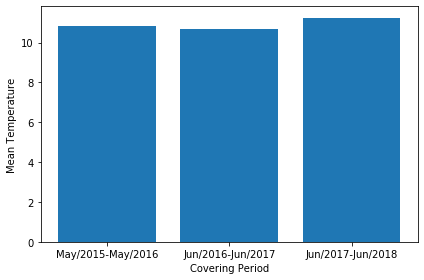

In [53]:
import numpy as np

y_pos = np.arange(len(list_TM_mean))
plt.ylabel('Mean Temperature')
plt.xlabel('Covering Period')
names=['May/2015-May/2016','Jun/2016-Jun/2017','Jun/2017-Jun/2018']
plt.bar(y_pos, list_TM_mean)
plt.xticks(y_pos,names)
plt.tight_layout()
plt.show()


In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# plot
sns.set_style('ticks')
fig1, ax1 = plt.subplots(dpi = 400, figsize = (12,24))

#sns.heatmap(df_merged_ts, cmap='RdYlGn_r', annot=False, ax = ax1)
sns.heatmap(df_merged_ts, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax1)

# _r reverses the normal order of the color map 'RdYlGn'

#sns.heatmap(df, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax)
ax1.set_yticklabels(df_merged_ts.index.strftime('%Y'))
plt.show()
fig1.savefig('example1.png')

In [55]:
df_merged_ts.to_csv(local_ts_merged_dir + "ts_merged.csv",sep=";")

In [56]:
df_merged_ts_transposed = df_merged_ts.transpose()

In [538]:
df_merged_ts_transposed.index.names = ['station_id']

In [539]:
df_merged_ts_transposed.head()

time        2015-05-01  2015-05-02  2015-05-03  2015-05-04  2015-05-05  \
station_id                                                               
2629               8.1        10.6        13.3        15.2        15.7   
1303               8.4        10.7        13.1        15.6        16.8   
5717               7.4         9.8        12.9        15.8        16.2   

time        2015-05-06  2015-05-07  2015-05-08  2015-05-09  2015-05-10  ...  \
station_id                                                              ...   
2629              11.3        10.7        13.2        13.9        13.2  ...   
1303              12.3        11.3        14.4        14.5        13.3  ...   
5717              11.7        11.5        13.6        14.7        13.7  ...   

time        2016-04-22  2016-04-23  2016-04-24  2016-04-25  2016-04-26  \
station_id                                                               
2629               9.7         6.6         3.6         4.0         3.6   
1303               9.8         6.2         3.4         3.6         2.9   
5717              10.6         6.2         3.1         3.9         3.3   

time        2016-04-27  2016-04-28  2016-04-29  2016-04-30  2016-05-01  
station_id                                                              
2629               5.4         4.9         6.8         8.5         8.3  
1303               3.8         4.8         6.8         6.6         9.1  
5717               4.3         4.8         7.3         7.4         9.5  

[3 rows x 367 columns]

In [540]:
df_merged_ts_transposed.to_csv(local_ts_merged_dir + "ts_merged_transposed.csv",sep=";")

In [541]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [542]:
df_appended_ts = ts_append()

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_02629_19471111_20181231_hist.zip
Extract product file: produkt_klima_tag_19471111_20181231_02629.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_01303_19350101_20181231_hist.zip
Extract product file: produkt_klima_tag_19350101_20181231_01303.txt

Zip archive: data/original/DWD//daily/kl/historical/tageswerte_KL_05717_19370101_20181231_hist.zip
Extract product file: produkt_klima_tag_19370101_20181231_05717.txt



In [543]:
df_appended_ts.head()

stations_id  qn_3  fx  fm  qn_4  rsk  rskf  sdk  shk_tag   nm  \
mess_datum                                                                  
1947-11-11         2629   NaN NaN NaN   5.0  7.5   1.0  NaN      0.0  8.0   
1947-11-12         2629   NaN NaN NaN   5.0  9.6   1.0  NaN      0.0  8.0   
1947-11-13         2629   NaN NaN NaN   5.0  4.9   1.0  NaN      0.0  7.0   
1947-11-14         2629   NaN NaN NaN   5.0  7.4   1.0  NaN      0.0  8.0   
1947-11-15         2629   NaN NaN NaN   5.0  6.1   1.0  NaN      0.0  6.3   

            ...   tnk  tgk  eor  date_from    date_to  altitude  latitude  \
mess_datum  ...                                                             
1947-11-11  ...   5.0  NaN  eor 1947-11-11 2020-02-06        46   51.7612   
1947-11-12  ...  10.7  NaN  eor 1947-11-11 2020-02-06        46   51.7612   
1947-11-13  ...   6.1  NaN  eor 1947-11-11 2020-02-06        46   51.7612   
1947-11-14  ...   4.5  NaN  eor 1947-11-11 2020-02-06        46   51.7612   
1947-11-15  ...   3.4  NaN  eor 1947-11-11 2020-02-06        46   51.7612   

           longitude   name                state  
mess_datum                                        
1947-11-11    6.0954  Kleve  Nordrhein-Westfalen  
1947-11-12    6.0954  Kleve  Nordrhein-Westfalen  
1947-11-13    6.0954  Kleve  Nordrhein-Westfalen  
1947-11-14    6.0954  Kleve  Nordrhein-Westfalen  
1947-11-15    6.0954  Kleve  Nordrhein-Westfalen  

[5 rows x 25 columns]

In [544]:
df_appended_ts.to_csv(local_ts_appended_dir + "ts_appended.csv",sep=";")